In [120]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

In [170]:
dpi = 175
fontsize = 10
plt.rc("savefig", dpi=dpi)
plt.rc('text', usetex=True)
plt.rc('font', size=fontsize)
plt.rc('xtick.major', pad=5)
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5)
plt.rc('ytick.minor', pad=5)

In [172]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

# Load Data

In [6]:
data_dir = '/Users/nora/Box/dssg/DrivenData/Heart/data/'

In [7]:
test = pd.read_csv(data_dir + 'test_values.csv')
train = pd.read_csv(data_dir + 'train_values.csv')
labels = pd.read_csv(data_dir + 'train_labels.csv')

In [8]:
npatients = len(train)

# Prepare Data

In [9]:
def convert_columns(df, cols=[]):
    for col in cols:
        df[col] = df[col].astype(str)
    return df
        
def standardize(df, numeric_only=True):
    numeric = df.select_dtypes(include=['int64', 'float64'])
    
    # subtracy mean and divide by std
    df[numeric.columns] = (numeric - numeric.mean()) / numeric.std()
    
    return df

def pre_process_data(df, enforce_cols=None):
    print("Input shape:\t{}".format(df.shape))
        

    df = standardize(df)
    print("After standardization {}".format(df.shape))
        
    # create dummy variables for categoricals
    df = pd.get_dummies(df)
    print("After converting categoricals:\t{}".format(df.shape))
    

    # match test set and training set columns
    if enforce_cols is not None:
        to_drop = np.setdiff1d(df.columns, enforce_cols)
        to_add = np.setdiff1d(enforce_cols, df.columns)

        df.drop(to_drop, axis=1, inplace=True)
        df = df.assign(**{c: 0 for c in to_add})
    
    df.fillna(0, inplace=True)
    
    return df

## Prepare Train

In [10]:
patient_id = train['patient_id'].as_matrix()
train = train.drop('patient_id', axis=1)
train = convert_columns(train, cols=['chest_pain_type', 'resting_ekg_results'])
train = pre_process_data(train)

Input shape:	(180, 13)
After standardization (180, 13)
After converting categoricals:	(180, 20)


In [11]:
train.head()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,thal_fixed_defect,thal_normal,thal_reversible_defect,chest_pain_type_1,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,resting_ekg_results_0,resting_ekg_results_1,resting_ekg_results_2
0,-0.888762,-0.194652,-0.716404,-0.437019,1.115158,-0.900694,0.670152,-1.051032,0.929891,-0.678852,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.727169,-1.252825,-0.716404,-0.437019,-0.667915,0.526148,-1.483908,-0.086892,0.386007,-0.678852,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.888762,-0.371014,2.378462,-0.437019,1.039283,-0.900694,0.670152,2.377024,0.567302,1.464891,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.888762,1.216246,-0.716404,-0.437019,-0.497195,-0.900694,0.670152,-1.586666,1.428452,-0.678852,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,2.343100,2.744719,-0.716404,-0.437019,0.394342,2.844768,0.670152,0.448742,-0.203201,-0.678852,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Prepare Labels

In [12]:
labels = np.ravel(labels.drop('patient_id', axis=1))

## Prepare Test

In [13]:
test_patient_id = test['patient_id'].as_matrix()
test = test.drop('patient_id', axis=1)
test = convert_columns(test, cols=['chest_pain_type', 'resting_ekg_results'])
test = pre_process_data(test)

Input shape:	(90, 13)
After standardization (90, 13)
After converting categoricals:	(90, 20)


## Split Data

In [14]:
train1, train2, labels1, labels2 = train_test_split(train, labels, train_size=0.75, test_size=0.25, shuffle=True)

# Prepare Submission

In [15]:
def prepare_submission(model, test, fname='submission.csv'):
    probs = model.predict_proba(test)
    sub = pd.DataFrame(np.vstack([test_patient_id, probs[:,1]]).T)
    sub.to_csv(fname, sep=',', header=['patient_id','heart_disease_present'], index=False)

In [16]:
def get_score(model, test, labels, printing=True):
    probs = model.predict_proba(test)
    preds = model.predict(test)
    if printing:
        print 'Accuracy: %.2f' %(model.score(test, labels)) # %(len(np.where(preds == labels))/len(preds))
        print 'Log loss: %.2f' %(log_loss(labels, probs))
    return log_loss(labels, probs)

# Extra Trees Classifier

In [17]:
# random forests are often a good model to try first, especially when we have numeric and categorical variables in our feature space.
def train_etc(features, labels, **kwargs):
    
    # instantiate model
    # model = RandomForestClassifier(n_estimators=50, random_state=0)
    model = ExtraTreesClassifier(n_estimators=50, random_state=0)
    
    # train model
    model.fit(features, labels)
    
    # get a (not-very-useful) sense of performance
    accuracy = model.score(features, labels)
    # print(f"In-sample accuracy: {accuracy:0.2%}")
    # print("In-sample accuracy: %.2f percent" %(accuracy*100))
    
    return model

In [18]:
model = train_etc(train1, labels1)

In [19]:
preds = model.predict(train2)
probs = model.predict_proba(train2)

In [20]:
print 'Accuracy: %.2f' %(model.score(train2, labels2))
print 'Log loss: %.2f' %(log_loss(labels2, probs))

Accuracy: 0.87
Log loss: 0.39


In [21]:
model = train_etc(train, labels)

In [22]:
probs = model.predict_proba(test)
preds = model.predict(test)

In [23]:
sub = pd.DataFrame(np.vstack([test_patient_id, probs[:,1]]).T)

In [24]:
sub.to_csv('submission1.csv', sep=',', header=['patient_id','heart_disease_present'], index=False)

In [25]:
prepare_submission(model, test, 'submission.csv')

# Visualize Score

In [103]:
def plot_results(labels, probs, thresh=0.5):
    plt.figure(figsize=(3,3))
    plt.scatter(labels, probs[:,1], edgecolor='none', c='cornflowerblue', s=40, alpha=0.5)
    plt.axhline(thresh, c='grey', alpha=0.2, lw=2, zorder=0, ls='--')
    plt.xlabel('True Classification')
    plt.ylabel('Model Probability')
    plt.title('log loss = %.2f'%log_loss(labels, probs))
    plt.xticks([0,1])
    plt.xlim(-0.5, 1.5)
    plt.show()
    
    
    fpr, tpr, thresh = roc_curve(labels2, probs[:,1])
    
    plt.figure(figsize=(3,3))
    plt.plot(fpr, tpr, 'cornflowerblue', lw=3)
    plt.xlabel('False Positives')
    plt.ylabel('True Positives')
    plt.title('ROC Curve')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.grid()
    plt.show()

In [27]:
model = train_etc(train1, labels1)

In [28]:
probs = model.predict_proba(train2)
preds = model.predict(train2)

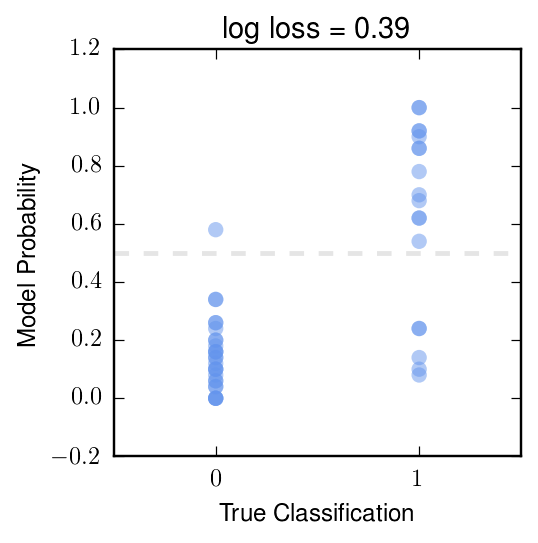

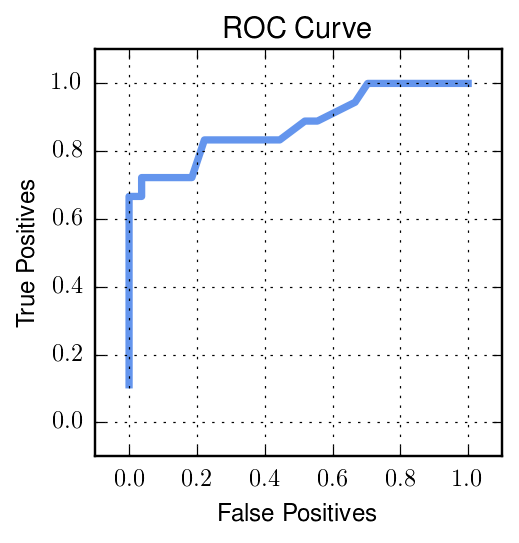

In [29]:
plot_results(labels2, probs)

In [56]:
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True, needs_threshold=False) 

In [107]:
ext = ExtraTreesClassifier(n_jobs=4, random_state=12)
# params = {'n_estimators':[10, 20, 50, 100, 200], 'criterion':['gini', 'entropy'], 'min_samples_split':[2, 3, 4, 5]}
params = {'n_estimators':[105, 110, 115, 120, 125, 130, 135, 140, 145], 'criterion':['gini'], 'min_samples_split':[5, 6, 7, 8]}

In [108]:
from sklearn.model_selection import RepeatedStratifiedKFold
kfold = RepeatedStratifiedKFold(n_splits=3, n_repeats=10)
ext_gs = GridSearchCV(ext, params, cv=kfold, return_train_score=True, scoring=log_loss_scorer)
ext_gs.fit(train, labels)

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x104723d10>,
       error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
           oob_score=False, random_state=12, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [105, 110, 115, 120, 125, 130, 135, 140, 145], 'min_samples_split': [5, 6, 7, 8], 'criterion': ['gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
       verbose=0)

In [136]:
print 'Best params: ', ext_gs.best_params_
print 'Best score: ', -ext_gs.best_score_
best_ext = ext_gs.best_estimator_

 Best params:  {'min_samples_split': 7, 'n_estimators': 145, 'criterion': 'gini'}
Best score:  0.45414763323


In [137]:
prepare_submission(best_ext, test, fname='submission_ext_cv_4.csv')

In [111]:
cv_res = ext_gs.cv_results_
mean_score = cv_res['mean_test_score']
idx = np.where(-mean_score == np.min(-mean_score))[0][0]
print idx
print cv_res['params'][idx]
print np.min(-mean_score)

26
{'min_samples_split': 7, 'n_estimators': 145, 'criterion': 'gini'}
0.45414763323


In [124]:
# cv_res

In [123]:
cv_train_mean = cv_res['mean_train_score']
cv_test_mean = cv_res['mean_test_score']
cv_train = np.concatenate([cv_res['split%i_train_score'%i] for i in range(10*3)])
cv_test = np.concatenate([cv_res['split%i_test_score'%i] for i in range(10*3)])

# plt.figure()

n_splits = 3
n_repeats = 10
# for i in range(n_repeats*n_splits):
#     plt.plot(np.arange(36), cv_res['split%i_test_score'%i])
    
# plt.ylim(-0.7, -0.3)
# plt.show()

In [ ]:
train1, train2, labels1, labels2 = train_test_split(train, labels, train_size=0.75, test_size=0.25, shuffle=True)
best_ext = ExtraTreesClassifier(n_jobs=4, n_estimators=135, criterion='gini', min_samples_split=5, random_state=12)
best_ext.fit(train1, labels1)
probs = best_ext.predict_proba(train2)
plot_results(labels2, probs)

In [62]:
ext = ExtraTreesClassifier(n_jobs=4, n_estimators=135, criterion='gini', min_samples_split=5, random_state=12)
ext.fit(train, labels)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=135, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

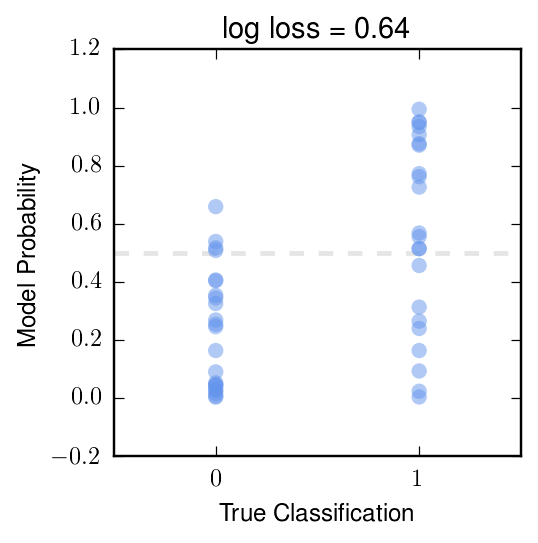

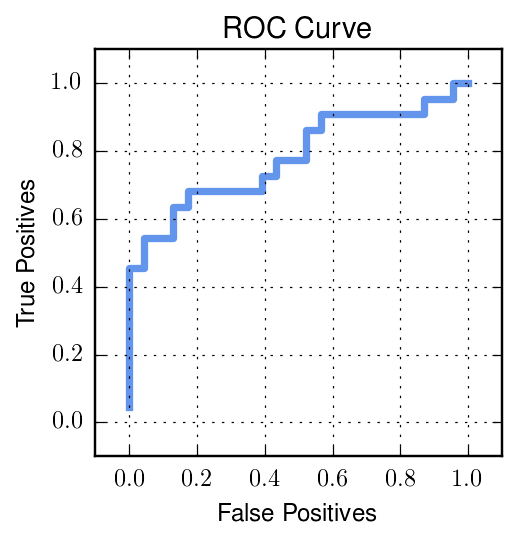

In [104]:
train1, train2, labels1, labels2 = train_test_split(train, labels, train_size=0.75, test_size=0.25, shuffle=True)
ext1 = ExtraTreesClassifier(n_jobs=4, n_estimators=135, criterion='gini', min_samples_split=5, random_state=12)
ext1.fit(train1, labels1)
probs = ext1.predict_proba(train2)
plot_results(labels2, probs)

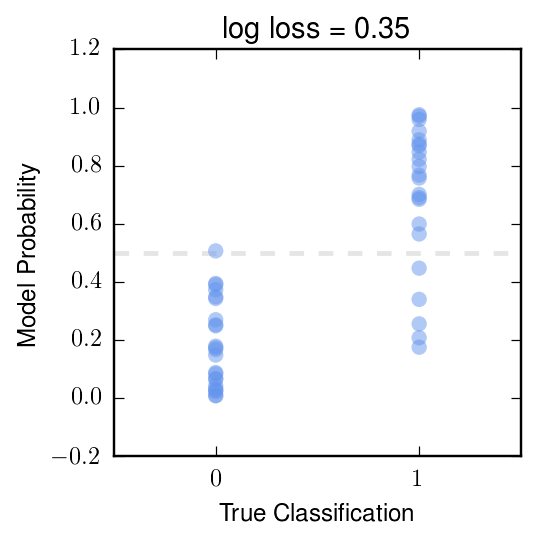

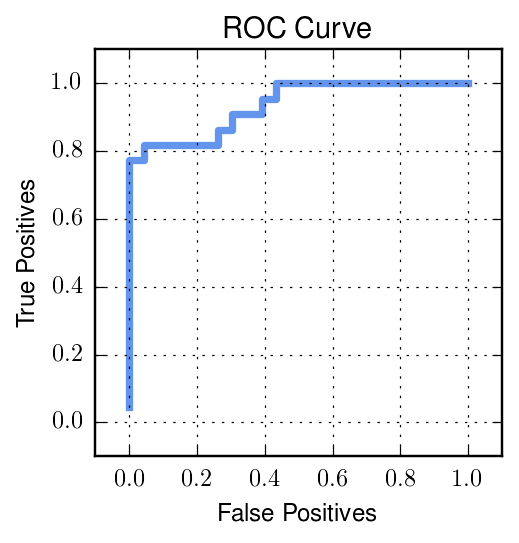

In [105]:
train1, train2, labels1, labels2 = train_test_split(train, labels, train_size=0.75, test_size=0.25, shuffle=True)
ext1 = ExtraTreesClassifier(n_jobs=4, n_estimators=140, criterion='gini', min_samples_split=6, random_state=12)
ext1.fit(train1, labels1)
probs = ext1.predict_proba(train2)
plot_results(labels2, probs)

# Random Search

In [190]:
from scipy.stats import truncnorm
from scipy.stats import randint
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
kfold = RepeatedStratifiedKFold(n_splits=3, n_repeats=10)

ext = ExtraTreesClassifier(n_jobs=4, random_state=12, criterion='gini')
# params_distributions = {'n_estimators':truncnorm(1, 500, loc=200, scale=100), 'min_samples_split':truncnorm(1, 10, loc=5, scale=2)}
# params_distributions = {'n_estimators':[105, 110, 115, 120, 125, 130, 135, 140, 145], 'criterion':['gini'], 'min_samples_split':[5, 6, 7, 8]}
params_distributions = {'n_estimators':randint(low=100, high=501), 'min_samples_split':randint(low=2, high=15)}

# ext_rs = RandomizedSearchCV(ext, params_distributions, cv=kfold, return_train_score=False, scoring=log_loss_scorer)
ext_rs = RandomizedSearchCV(ext, params_distributions, cv=loo, return_train_score=True, n_iter=100)
ext_rs.fit(X=train, y=labels)

RandomizedSearchCV(cv=LeaveOneOut(), error_score='raise',
          estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
           oob_score=False, random_state=12, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112379ed0>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112bdc5d0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [147]:
print 'Best params: ', ext_rs.best_params_
print 'Best score: ', -ext_rs.best_score_
best_ext = ext_rs.best_estimator_

Best params:  {'min_samples_split': 2, 'n_estimators': 30}
Best score:  -0.827777777778


In [199]:
print 'Best params: ', ext_rs.best_params_
print 'Best score: ', -ext_rs.best_score_
best_ext = ext_rs.best_estimator_

Best params:  {'min_samples_split': 3, 'n_estimators': 276}
Best score:  -0.833333333333


In [200]:
prepare_submission(best_ext, test, fname='submission_ext_rscv_loo_100.csv')

In [193]:
cv_res = ext_rs.cv_results_

In [194]:
cv_res

{'mean_fit_time': array([ 2.62766033,  1.88566942,  2.52319715,  3.24984958,  3.81587924,
         2.18046818,  1.91225657,  1.11293158,  2.69325432,  2.5061524 ,
         1.66364821,  1.11956526,  2.10399509,  0.84809155,  2.23617238,
         1.30712533,  2.46383493,  0.970576  ,  1.40709345,  0.7215046 ,
         0.68834313,  0.79002854,  1.13465609,  1.84187748,  2.30465621,
         0.73991751,  0.70818573,  1.85837611,  2.38369555,  1.88585969,
         0.93337421,  1.9116375 ,  1.95494949,  1.31508692,  2.11335386,
         1.11327993,  2.10325811,  1.06608999,  2.17053584,  2.20119921,
         0.95916405,  1.56183732,  1.66461675,  0.64401027,  1.64230191,
         1.31140222,  1.45415859,  1.9857146 ,  0.63135942,  1.65961569,
         0.98160733,  1.79341169,  1.72316822,  1.8273875 ,  1.67614769,
         0.73701073,  2.19688778,  0.96008015,  1.62642806,  0.7008063 ,
         1.72324293,  0.87930593,  1.26266279,  1.76559513,  0.57631201,
         1.71017154,  1.28165878, 

In [195]:
mss = np.array([cv_res['params'][i]['min_samples_split'] for i in range(len(cv_res['params']))])
nest = np.array([cv_res['params'][i]['n_estimators'] for i in range(len(cv_res['params']))])
mean_score = cv_res['mean_test_score']
print mss.shape, nest.shape, mean_score.shape

(100,) (100,) (100,)


In [196]:
M, N = np.meshgrid(mss, nest)

[ 3  2  3 13  3 11 13  7 12  3 14  3  2 10 13  3 13 14 11  3 10  5  2  8 11
  3  4 10  4  6  6 11  2 11  7  2  5  8 13  3 13 11  3  9  4  3 14 11  8 11
 10 12  8  7  5  4  4 11 11  4  7 13 13 10  8 13 10 14 14 10  9  5  6 13  2
  7  3  9  4 10  7  8  8  2  2  4  5  3  9 10 11  6  7  7  3 11  8 11  8 11]
[229 175 217 287 388 278 241 139 394 412 354 229 478 185 460 247 441 204
 292 128 129 164 235 295 457 115 122 374 474 360 203 431 435 288 469 232
 468 226 487 496 213 344 363 121 359 290 328 453 118 364 219 401 384 414
 371 152 490 215 355 135 385 194 279 397 112 382 283 147 127 195 461 406
 247 163 308 354 276 357 423 365 277 137 426 489 196 304 176 410 373 220
 115 434 261 309 324 447 120 247 230 387]


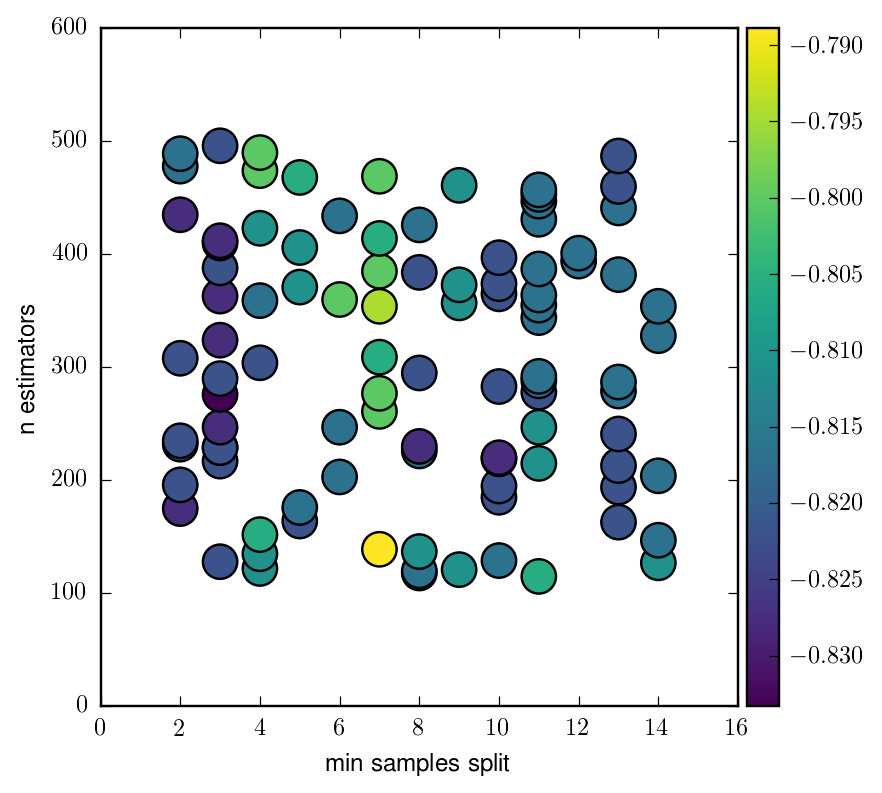

In [197]:
print mss
print nest

idx = np.argsort(nest)

# cut = (nest != np.min(nest))

plt.figure(figsize=(5,5))
sc = plt.scatter(mss[idx][2:], nest[idx][2:], c=-mean_score[idx][2:], cmap='viridis', s=200)
plt.xlabel('min samples split')
plt.ylabel('n estimators')
colorbar(sc)
plt.show()